# Exploratory Data Analysis (EDA) — Reference Data Understanding

## Objective
The goal of this notebook is to understand the structure, quality, and behavior of the raw dataset **before** defining reference data and simulated production batches.

This analysis focuses on:
- Feature types and distributions
- Target imbalance
- Data quality issues
- Identification of features relevant for drift and bias monitoring

No data cleaning, encoding, or modeling is performed in this notebook.


In [154]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Display settings
pd.set_option("display.max_columns", None)
sns.set(style="whitegrid")


In [155]:
RAW_DATA_PATH = Path("data/raw/telco_customer_churn.csv")

df = pd.read_csv(RAW_DATA_PATH)

In [156]:
import os
os.getcwd()

'/Users/sykambharath/ML_Model_Monitoring'

In [157]:
df.shape

(7043, 21)

In [158]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [159]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


## Important column observations


In [160]:
# Target Variable
df["Churn"].value_counts()
df["Churn"].value_counts(normalize=True)

Churn
No     0.73463
Yes    0.26537
Name: proportion, dtype: float64

## Target Variable Analysis — Churn

The target variable **Churn** represents whether a customer has discontinued the service.
Understanding the distribution of the target variable is a critical first step because it directly influences:

- Model evaluation strategy  
- Monitoring metrics in production  
- Business risk associated with model failure  

### Class Distribution

The dataset shows the following class proportions:

- **Non-churn (No): ~73.5%**
- **Churn (Yes): ~26.5%**

This indicates a **moderately imbalanced classification problem**.

### Implications for Modeling and Monitoring

Because churned customers represent a minority class but carry **high business impact**, overall accuracy is not a sufficient metric. A model that predicts “No churn” most of the time can still appear accurate while failing to identify at-risk customers.

As a result:

- **Recall for the churn class** is a critical metric, as false negatives correspond to customers who leave without intervention.
- **Precision** is also monitored to control the cost of unnecessary retention actions.
- **ROC-AUC** is used as a threshold-independent metric to track ranking quality over time.

### Monitoring Perspective

In production, a silent drop in **churn recall** is more dangerous than a small drop in accuracy. Therefore, recall for the churn class will be explicitly tracked and monitored across production batches to detect performance degradation early.

In [161]:
# classification of feature types
categorical_features = df.select_dtypes(include=["object"]).columns.tolist()
numerical_features = df.select_dtypes(exclude=["object"]).columns.tolist()

categorical_features, numerical_features

(['customerID',
  'gender',
  'Partner',
  'Dependents',
  'PhoneService',
  'MultipleLines',
  'InternetService',
  'OnlineSecurity',
  'OnlineBackup',
  'DeviceProtection',
  'TechSupport',
  'StreamingTV',
  'StreamingMovies',
  'Contract',
  'PaperlessBilling',
  'PaymentMethod',
  'TotalCharges',
  'Churn'],
 ['SeniorCitizen', 'tenure', 'MonthlyCharges'])

### observations:
- `SeniorCitizen` is numeric but represents a binary category.
- `TotalCharges` appears numeric but is stored as string in raw data.
- Feature type decisions will directly affect drift detection logic later.


In [162]:
# Missing values 
df.isna().sum().sort_values(ascending=False)

customerID          0
DeviceProtection    0
TotalCharges        0
MonthlyCharges      0
PaymentMethod       0
PaperlessBilling    0
Contract            0
StreamingMovies     0
StreamingTV         0
TechSupport         0
OnlineBackup        0
gender              0
OnlineSecurity      0
InternetService     0
MultipleLines       0
PhoneService        0
tenure              0
Dependents          0
Partner             0
SeniorCitizen       0
Churn               0
dtype: int64

In [163]:
df["MonthlyCharges"].describe()

count    7043.000000
mean       64.761692
std        30.090047
min        18.250000
25%        35.500000
50%        70.350000
75%        89.850000
max       118.750000
Name: MonthlyCharges, dtype: float64

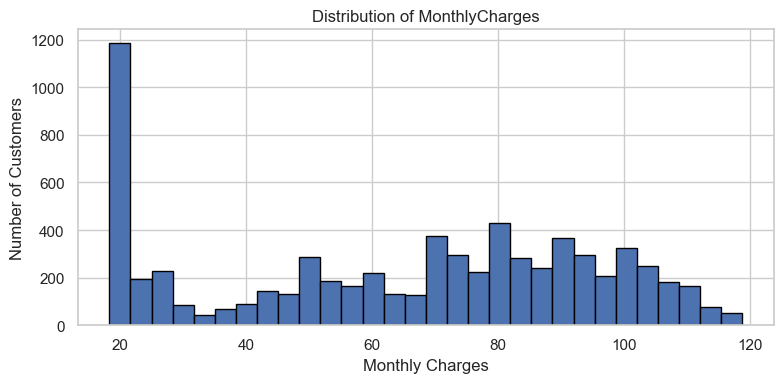

In [164]:
plt.figure(figsize=(8, 4))
plt.hist(df["MonthlyCharges"], bins=30, edgecolor="black")
plt.title("Distribution of MonthlyCharges")
plt.xlabel("Monthly Charges")
plt.ylabel("Number of Customers")
plt.tight_layout()
plt.show()

In [165]:
df.groupby("Churn")["MonthlyCharges"].describe()

,count,mean,std,min,25%,50%,75%,max
Churn,,,,,,,,
No,5174.0,61.265124,31.092648,18.25,25.10,64.425,88.4,118.75
Yes,1869.0,74.441332,24.666053,18.85,56.15,79.650,94.2,118.35


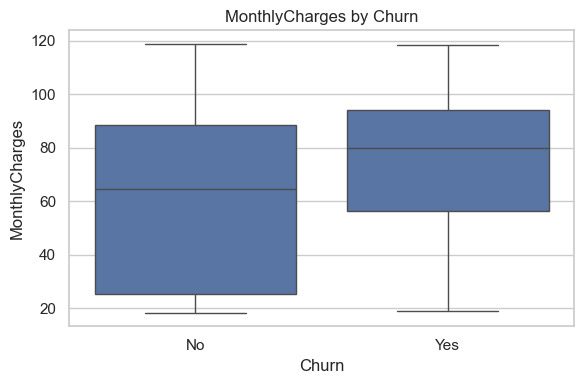

In [166]:
plt.figure(figsize=(6, 4))
sns.boxplot(x="Churn", y="MonthlyCharges", data=df)
plt.title("MonthlyCharges by Churn")
plt.tight_layout()
plt.show()

### Feature Analysis — MonthlyCharges

**MonthlyCharges** represents the amount billed to a customer each month for telecom services.
### Distribution Overview

From the descriptive statistics:
- **Range:** 18.25 to 118.75
- **Median:** 70.35
- **Interquartile range (IQR):** 35.50 to 89.85
- **Mean:** ~64.76

The histogram shows a **multi-modal and right-skewed distribution**, with:
- A concentration of customers at lower charges (basic services)
- Distinct peaks at mid-to-high charge ranges (bundled or premium services)

### Relationship with Churn

Statistics reveal a clear pricing effect:

**Non-churned customers**
- Mean MonthlyCharges: ~61.3
- Median MonthlyCharges: ~64.4

**Churned customers**
- Mean MonthlyCharges: ~74.4
- Median MonthlyCharges: ~79.7

The boxplot confirms that:
- Churned customers tend to pay **significantly higher monthly charges**
- The entire distribution for churned customers is shifted upward

This suggests that **higher pricing is associated with increased churn risk**, potentially due to:
- Price sensitivity

### Modeling Implications

- **MonthlyCharges** is a strong predictive feature for churn
- It should be retained as a continuous numeric variable
- Linear models can leverage its monotonic relationship with churn

### Monitoring & Drift Implications

- Drift in MonthlyCharges can cause **rapid performance degradation**
- Drift in this feature should contribute strongly to overall drift severity

Given its business and predictive importance, **MonthlyCharges drift should trigger early alerts**. 

In [167]:
# Evaluation of Totalcharges column
# blank strings in TotalCharges
num_blank = (df["TotalCharges"].str.strip() == "").sum()
num_blank


np.int64(11)

In [168]:
# rows with blank TotalCharges
blank_values = df["TotalCharges"].str.strip() == ""
df.loc[blank_values, ["customerID", "tenure", "MonthlyCharges", "TotalCharges", "Churn"]]
df.loc[blank_values]

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
488,4472-LVYGI,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,No,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,,No
753,3115-CZMZD,Male,0,No,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,,No
936,5709-LVOEQ,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,,No
1082,4367-NUYAO,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,,No
1340,1371-DWPAZ,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,Yes,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,,No
3331,7644-OMVMY,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,,No
3826,3213-VVOLG,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,,No
4380,2520-SGTTA,Female,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,,No
5218,2923-ARZLG,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,,No
6670,4075-WKNIU,Female,0,Yes,Yes,0,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,,No


### Interpretation & Findings

The `TotalCharges` feature is conceptually a **numeric financial variable**, but it is stored as an `object` type in the dataset. Exploratory analysis reveals the presence of **blank string values**, which represent missing information rather than valid numeric entries.

Inspection of the affected rows shows that blank `TotalCharges` values are primarily associated with customers who have **very low tenure**, indicating newly onboarded customers who have not yet accumulated billing history. This suggests the issue arises from the **data generation process** rather than random data corruption.

If left unaddressed, this column introduces multiple risks:

- Model training may fail or behave inconsistently due to non-numeric inputs.
- Statistical drift metrics (mean shift, PSI) may produce misleading or false alerts.
- Explainability techniques (e.g., SHAP) may break or yield unstable results.
- Schema violations could occur silently in production, reducing trust in monitoring outputs.

To ensure schema consistency and reliable downstream monitoring, blank strings in `TotalCharges` must be converted to `NaN`, followed by explicit numeric casting and deterministic handling of missing values. This step is treated as **data contract enforcement**, not optional cleaning.

Because `TotalCharges` is a high-impact financial feature, it should only be monitored after proper numeric conversion. Any future appearance of non-numeric values should be flagged as a **schema-level inconsistency** rather than interpreted as genuine data drift.


In [169]:
df["tenure"].describe()

count    7043.000000
mean       32.371149
std        24.559481
min         0.000000
25%         9.000000
50%        29.000000
75%        55.000000
max        72.000000
Name: tenure, dtype: float64

In [170]:
df.groupby("Churn")["tenure"].describe()

,count,mean,std,min,25%,50%,75%,max
Churn,,,,,,,,
No,5174.0,37.569965,24.113777,0.0,15.0,38.0,61.0,72.0
Yes,1869.0,17.979133,19.531123,1.0,2.0,10.0,29.0,72.0


<Axes: xlabel='Churn', ylabel='tenure'>

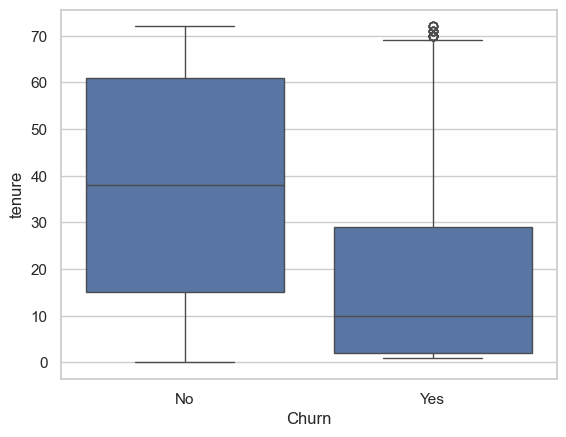

In [171]:
sns.boxplot(x="Churn", y="tenure", data=df)

### Interpretation & Findings
`tenure` measures the number of months a customer has stayed with the service.  
It is a continuous numeric feature with a strong behavioral interpretation: **customer loyalty and lifecycle stage**.

### Distribution Overview

From the descriptive statistics:

- **Range:** 0 to 72 months  
- **Median tenure:** 29 months  
- **Interquartile range (IQR):** 9 to 55 months  
- The distribution is **right-skewed**, with many short-tenure customers and a long tail of long-term subscribers.

### Relationship with Churn

- **Non-churned customers**
  - Mean tenure: ~37.6 months  
  - Median tenure: 38 months  

- **Churned customers**
  - Mean tenure: ~18.0 months  
  - Median tenure: 10 months  

The boxplot confirms that:

- Customers who churn tend to do so **early in their lifecycle**
- Long-tenure customers are **significantly more stable**
This makes `tenure` one of the **strongest predictive drivers of churn** in the dataset.

### Monitoring & Drift Implications

`tenure` is a **high-risk feature for data drift** because:

- New customer acquisition strategies can shift the distribution
- Pricing or onboarding changes may increase short-tenure users
- Seasonal campaigns can alter lifecycle composition

Because of its strong influence on predictions:
- Even **moderate drift** in `tenure` can cause performance degradation


/var/folders/zx/zzkcz9dd5lbc989qgmmvx9mh0000gn/T/ipykernel_92796/3119325842.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


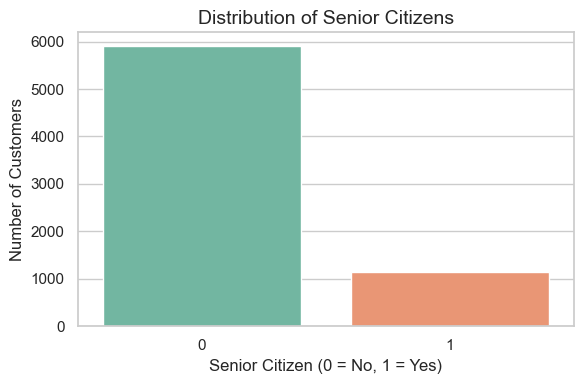

In [172]:
# SENIOR CITIZEN

plt.figure(figsize=(6, 4))
sns.countplot(
    x="SeniorCitizen",
    data=df,
    palette="Set2"
)

plt.title("Distribution of Senior Citizens", fontsize=14)
plt.xlabel("Senior Citizen (0 = No, 1 = Yes)")
plt.ylabel("Number of Customers")

plt.tight_layout()
plt.show()

In [173]:
for col in categorical_features:
    print(f"\n{col}")
    display(df[col].value_counts().head())


customerID


customerID
7590-VHVEG    1
3791-LGQCY    1
6008-NAIXK    1
5956-YHHRX    1
5365-LLFYV    1
Name: count, dtype: int64


gender


gender
Male      3555
Female    3488
Name: count, dtype: int64


Partner


Partner
No     3641
Yes    3402
Name: count, dtype: int64


Dependents


Dependents
No     4933
Yes    2110
Name: count, dtype: int64


PhoneService


PhoneService
Yes    6361
No      682
Name: count, dtype: int64


MultipleLines


MultipleLines
No                  3390
Yes                 2971
No phone service     682
Name: count, dtype: int64


InternetService


InternetService
Fiber optic    3096
DSL            2421
No             1526
Name: count, dtype: int64


OnlineSecurity


OnlineSecurity
No                     3498
Yes                    2019
No internet service    1526
Name: count, dtype: int64


OnlineBackup


OnlineBackup
No                     3088
Yes                    2429
No internet service    1526
Name: count, dtype: int64


DeviceProtection


DeviceProtection
No                     3095
Yes                    2422
No internet service    1526
Name: count, dtype: int64


TechSupport


TechSupport
No                     3473
Yes                    2044
No internet service    1526
Name: count, dtype: int64


StreamingTV


StreamingTV
No                     2810
Yes                    2707
No internet service    1526
Name: count, dtype: int64


StreamingMovies


StreamingMovies
No                     2785
Yes                    2732
No internet service    1526
Name: count, dtype: int64


Contract


Contract
Month-to-month    3875
Two year          1695
One year          1473
Name: count, dtype: int64


PaperlessBilling


PaperlessBilling
Yes    4171
No     2872
Name: count, dtype: int64


PaymentMethod


PaymentMethod
Electronic check             2365
Mailed check                 1612
Bank transfer (automatic)    1544
Credit card (automatic)      1522
Name: count, dtype: int64


TotalCharges


TotalCharges
         11
20.2     11
19.75     9
20.05     8
19.9      8
Name: count, dtype: int64


Churn


Churn
No     5174
Yes    1869
Name: count, dtype: int64

### Findings
Categorical features like Contract and PaymentMethod are strong candidates for:
- Data drift monitoring
- Bias and fairness analysis


### Sensitive Attributes for Bias Monitoring

The following features are identified as sensitive or fairness-relevant:
- gender
- SeniorCitizen
- Partner
- Dependents

These attributes will be used later to compute group-level performance metrics.

### EDA Conclusions

- Dataset contains both numerical and categorical features with realistic business meaning.
- Target variable is moderately imbalanced.
- `TotalCharges` requires cleaning due to invalid values.
- Several features are strong candidates for drift monitoring.
- Sensitive attributes are present, enabling bias analysis.